In [99]:
import datetime
import re
import json
import yaml
import sys
import os
import logging
import logging.config
import time
import multiprocessing
from collections import OrderedDict
import requests
import string
import unicodedata
import yaml
import warnings
warnings.filterwarnings('ignore')

########################################
# external libs
########################################
import joblib
from joblib import delayed, Parallel

########################################
# ml
########################################
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    balanced_accuracy_score,
    average_precision_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

#################################
# VARIÁVEIS GLOBAIS
#################################
N_JOBS = 6
BASE_DIR = './'
DEFAULT_RANDOM_STATE = 42

#################################
# LOGS
#################################
with open(os.path.join(BASE_DIR, 'log.conf.yaml'), 'r') as f:
    config = yaml.safe_load(f.read())
    logging.config.dictConfig(config)

In [100]:
class TextCleaner(BaseEstimator, TransformerMixin):
    stop_words = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no',
                  'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu',
                  'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo',
                  'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem',
                  'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu',
                  'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe',
                  'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes',
                  'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas',
                  'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está',
                  'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam',
                  'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos',
                  'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve',
                  'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse',
                  'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos',
                  'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram',
                  'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos',
                  'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos',
                  'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos',
                  'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem',
                  'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

    def __init__(self, n_jobs=1):
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sX = pd.Series(X)

        def tratar_texto(t):

            if not t:
                return ''
            if type(t) != str:
                t = str(t)

            t = t.replace('\\n', ' ')
            t = t.replace('null', ' ')
            t = t.lower()
            regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
            t = regex.sub(" ", t)
            lista = t.split()

            # retira stopwords e sinais de pontuação
            lista = [palavra for palavra in lista if palavra not in self.stop_words and palavra not in string.punctuation]

            # retira os dígitos
            lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
            lista = lista.replace('\n', ' ').replace('\r', ' ')
            lista = lista.replace(' o ', ' ').replace(' a ', ' ').replace(' os ', ' ').replace(' as ',
                                                                                               ' ')  # retira o, a, os, as que ainda permaneceiam no texto
            lista = re.sub(r" +", ' ', lista)  # retira espaços em excesso

            nfkd = unicodedata.normalize('NFKD', lista)
            lista = u"".join([c for c in nfkd if not unicodedata.combining(c)])  # retira acento

            return lista

        def tratar_serie(s):
            return s.apply(tratar_texto)

        split = np.array_split(sX, self.n_jobs)
        r = Parallel(n_jobs=self.n_jobs, verbose=0)(delayed(tratar_serie)(s) for s in split)
        return pd.concat(r)


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, default_value=0):
        self.feature_names = feature_names
        self.default_value = default_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # incluir teste para colunas ausentes
        X = X.copy()
        for c in self.feature_names:
            if c not in X.columns:
                X[c] = self.default_value
        return X[self.feature_names]

In [101]:
# Leitura dos dados estruturados extraídos das denúncias. 
# Informações completamente anonimizadas.
df = pd.read_parquet('datasets/dataset_dados_estruturados.parquet')

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['LABEL']), df['LABEL'], test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=df['LABEL'])

# altera a escala das features para um intervalo entre 0 e 1.
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

NUMERO_FEATURES = X_train.shape[1]

# Modelo baseado em dados estruturados

In [102]:
k = 20
selector_model=RandomForestClassifier(
    n_estimators=1000, 
    class_weight=class_weight, 
    random_state=DEFAULT_RANDOM_STATE, 
    n_jobs=N_JOBS)

selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

In [103]:
params = [2072, 7, 10, 1, 0.8490335468529386, 2]

n_estimators = params[0] 
max_depth = params[1]
min_samples_split = params[2]
min_samples_leaf = params[3]
max_samples = params[4]
class_weight = {0: 1, 1: params[5]}

model_de = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_samples=max_samples,
                             class_weight=class_weight,
                             random_state=DEFAULT_RANDOM_STATE, 
                             n_jobs=-1)

model_de.fit(X_train, y_train)

p_de = model_de.predict(X_test)

In [104]:
round(balanced_accuracy_score(y_test, p_de),2)

0.76

In [105]:
round(roc_auc_score(y_test, model_de.predict_proba(X_test)[:,1]),2)

0.82

In [106]:
print(confusion_matrix(y_test, p_de))

[[191  29]
 [ 27  51]]


In [107]:
print(classification_report(y_test, p_de))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       220
           1       0.64      0.65      0.65        78

    accuracy                           0.81       298
   macro avg       0.76      0.76      0.76       298
weighted avg       0.81      0.81      0.81       298



In [108]:
round(f1_score(y_test, p_de, average='macro',),2)

0.76

In [109]:
round(average_precision_score(y_test, p_de),2)

0.51

# Modelo baseado em textos

In [110]:
df = pd.read_parquet('dados_nao_anonimizados/df_completo_rotulado.parquet')
df['TextoCompleto'] = df['TxtFatoManifestacao'].str.cat(df['TextoAnexo'], sep=' ').astype(str)
X_txt, y_txt = df[['TextoCompleto']], df['GrauAptidao'].apply(lambda x: 1 if x>50 else 0)

In [111]:
%%time
# preprocessamento do texto (remoção de stopwords, remoção de acentos, remoção de pontuações, remoção de números, transformação de todos os caracteres em lowercase)
X_txt = TextCleaner(n_jobs=N_JOBS).fit_transform(X_txt['TextoCompleto']).to_frame()

Wall time: 29.9 s


In [112]:
X_txt_train, X_txt_test, y_txt_train, y_txt_test = train_test_split(X_txt, y_txt, test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=y_txt) 

In [113]:
params = [561, 8, 4.224223904903976, 0.02244487129310769, 0.7238152794334479, 2.937888316662603, 4.82662398324805, 5, 0.7713480415791243, 2162, 1]
params = [164, 7, 2.122773388724785, 0.011906957393449534, 0.576092904830823, 0.08025831534827145, 1.0022235964031379, 5, 0.8645035840204938, 4574, 1]

scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]
n_estimators = params[0] 
max_depth = params[1]
reg_lambda = params[2]
learning_rate = params[3]
subsample = params[4]
reg_alpha = params[5]
gamma = params[6]
min_df = params[7]
max_df = params[8]
max_features = params[9]
ngram_range = (1, params[10])

tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, ngram_range=ngram_range)
tfidf.fit(X_txt_train['TextoCompleto'])

X_txt_train_idf = tfidf.transform(X_txt_train['TextoCompleto'])
X_txt_test_idf = tfidf.transform(X_txt_test['TextoCompleto'])

scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]

model_txt = XGBClassifier(base_score=None, colsample_bylevel=None,
           colsample_bynode=None, colsample_bytree=None, gamma=gamma,
           gpu_id=None, importance_type='gain', interaction_constraints=None,
           learning_rate=learning_rate, max_delta_step=None, max_depth=max_depth,
           n_estimators=n_estimators, n_jobs=None, num_parallel_tree=None,
           random_state=DEFAULT_RANDOM_STATE, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
           scale_pos_weight=scale_pos_weight, subsample=subsample, tree_method=None,
           validate_parameters=None, verbosity=None)

model_txt.fit(X_txt_train_idf, y_txt_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0022235964031379,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.011906957393449534, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=164, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0.08025831534827145, reg_lambda=2.122773388724785,
              scale_pos_weight=2.7929936305732483, subsample=0.576092904830823,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [114]:
round(balanced_accuracy_score(y_txt_test, model_txt.predict(X_txt_test_idf) ),2)

0.71

In [115]:
round(roc_auc_score(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:, 1] ),2)

0.84

In [116]:
print(classification_report(y_txt_test, model_txt.predict(X_txt_test_idf) ))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       220
           1       0.57      0.58      0.57        78

    accuracy                           0.78       298
   macro avg       0.71      0.71      0.71       298
weighted avg       0.78      0.78      0.78       298



In [117]:
print(confusion_matrix(y_txt_test, model_txt.predict(X_txt_test_idf) ))

[[186  34]
 [ 33  45]]


In [118]:
round(f1_score(y_txt_test, model_txt.predict(X_txt_test_idf), average='macro'),2)

0.71

In [119]:
round(average_precision_score(y_txt_test, model_txt.predict(X_txt_test_idf)),2)

0.44

# Modelos Combinados

In [151]:
proba_de = model_de.predict_proba(X_test)[:, 1]
proba_txt = model_txt.predict_proba(X_txt_test_idf)[:, 1]

In [152]:
def calc_label(v):
    if v >= .5:
        return 1
    else:
        return 0
calc_label_v = np.vectorize(calc_label)

# média

In [153]:
p_comb_v01 = (proba_de + proba_txt)/2

In [154]:
print(confusion_matrix(y_test, calc_label_v(p_comb_v01)))

[[194  26]
 [ 26  52]]


In [155]:
print(classification_report(y_test, calc_label_v(p_comb_v01)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       220
           1       0.67      0.67      0.67        78

    accuracy                           0.83       298
   macro avg       0.77      0.77      0.77       298
weighted avg       0.83      0.83      0.83       298



In [156]:
round(roc_auc_score(y_test.values, p_comb_v01),3)

0.85

In [157]:
round(balanced_accuracy_score(y_test.values, calc_label_v(p_comb_v01)),3)

0.774

In [158]:
round(f1_score(y_test.values, calc_label_v(p_comb_v01)),3)

0.667

In [159]:
round(average_precision_score(y_test.values, calc_label_v(p_comb_v01)),3)

0.532

# maior

In [160]:
p_comb_v02 = [np.max([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)]

In [161]:
print(confusion_matrix(y_test, calc_label_v(p_comb_v02)))

[[174  46]
 [ 23  55]]


In [162]:
print(classification_report(y_test, calc_label_v(p_comb_v02)))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       220
           1       0.54      0.71      0.61        78

    accuracy                           0.77       298
   macro avg       0.71      0.75      0.72       298
weighted avg       0.79      0.77      0.78       298



In [166]:
round(roc_auc_score(y_test.values, p_comb_v02),3)

0.842

In [167]:
round(balanced_accuracy_score(y_test.values, calc_label_v(p_comb_v02)),3)

0.748

In [168]:
round(average_precision_score(y_test, calc_label_v(p_comb_v02)),3)

0.461

In [169]:
round(f1_score(y_test, calc_label_v(p_comb_v02)),3)

0.615

# menor

In [170]:
p_comb_v03 = calc_label_v(proba_de) & calc_label_v(proba_txt)

In [171]:
print(confusion_matrix(y_test, p_comb_v03))

[[203  17]
 [ 37  41]]


In [172]:
print(confusion_matrix(y_test, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])))

[[203  17]
 [ 37  41]]


In [173]:
print(classification_report(y_test, p_comb_v03))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       220
           1       0.71      0.53      0.60        78

    accuracy                           0.82       298
   macro avg       0.78      0.72      0.74       298
weighted avg       0.81      0.82      0.81       298



In [174]:
round(roc_auc_score(y_test.values, [np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)]),3)

0.834

In [175]:
round(balanced_accuracy_score(y_test.values, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.724

In [176]:
round(recall_score(y_test.values, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.526

In [177]:
round(f1_score(y_test.values, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.603

In [178]:
round(average_precision_score(y_test, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.496

# ROC_AUC Comparativo

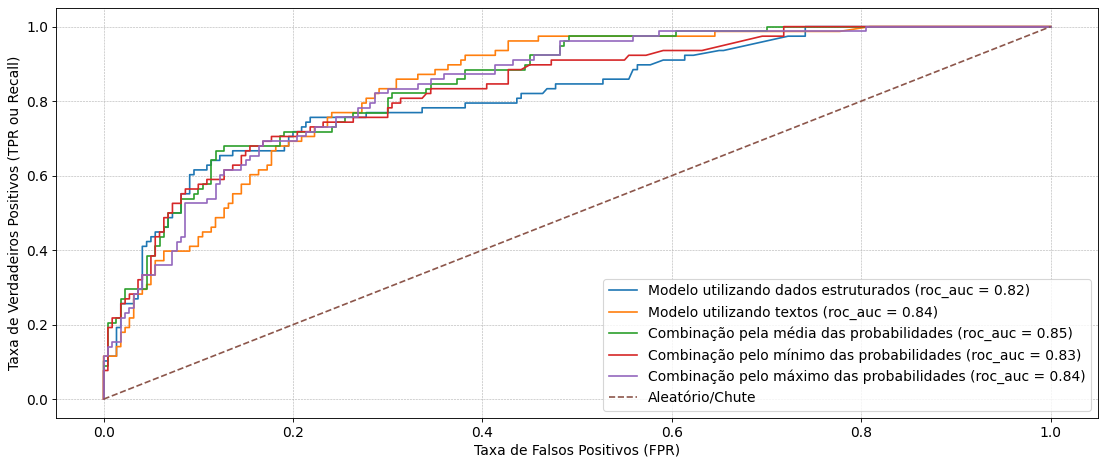

In [179]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
# plt.title(' Curva Característica de Operação do Receptor (ROC)')
lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, model_de.predict_proba(X_test)[:,1], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, model_de.predict_proba(X_test)[:,1])
plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando dados estruturados (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, model_txt.predict_proba(X_txt_test_idf)[:,1], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, model_txt.predict_proba(X_txt_test_idf)[:,1])
plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando textos (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pela média das probabilidades (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pelo mínimo das probabilidades (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.max([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.max([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pelo máximo das probabilidades (roc_auc = {:.2f})'.format(score))

# lr_fpr, lr_tpr, thresholds =  roc_curve(y_test.values, , drop_intermediate=False, pos_label=1)
# plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando textos',color='#45B39D')


plt.plot([0, 1], [0,1], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00600_roc_auc_texto.png')
plt.show()